In [1]:
import pandas as pd
import numpy as np

def create_timeseries_for_symbol(df, symbol_id):
    """
    Create feature and responder time series for a given symbol
    
    Args:
        df: Input dataframe
        symbol_id: Symbol to process
    
    Returns:
        tuple: (feature_series, responder_series)
    """
    # Sort by date_id and time_id, then filter for our symbol
    df_sorted = df.sort_values(['date_id', 'time_id'])
    symbol_data = df_sorted[df_sorted['symbol_id'] == symbol_id].copy()
    
    # Get column names
    feature_cols = [col for col in df.columns if col.startswith('feature_')]
    responder_cols = [col for col in df.columns if col.startswith('responder_') and col != 'responder_6']

    target_col = 'responder_6'
    
    # Get first date and its last time for responders
    first_date = symbol_data['date_id'].min()
    first_date_last_time = symbol_data[symbol_data['date_id'] == first_date]['time_id'].max()
    first_date_last_responders = symbol_data[
        (symbol_data['date_id'] == first_date) & 
        (symbol_data['time_id'] == first_date_last_time)
    ][responder_cols]
    
    # Get all data after first date (for features)
    feature_series = symbol_data[symbol_data['date_id'] > first_date][feature_cols].copy()

    # Get all data after first date (for target)
    target_series = symbol_data[symbol_data['date_id'] > first_date][target_col].copy()

    # Get all data after first date except the last row (for responders)
    responder_data = symbol_data[symbol_data['date_id'] > first_date][responder_cols].iloc[:-1]
    
    # Add first date's last responders at the start
    responder_series = pd.concat([first_date_last_responders, responder_data])
    
    # Print verification
    print(f"\nFeature series shape: {feature_series.shape}")
    print("\nFirst few rows of feature series:")
    print(feature_series.head())

    print(f"\nResponder series shape: {responder_series.shape}")
    print("\nFirst few rows of responder series (should start with final time_id of first date):")
    print(responder_series.head())

    print(f"\nTarget series shape: {target_series.shape}")
    print("\nFirst few rows of target series:")
    print(target_series.head())

    return feature_series, responder_series, target_series

# Example usage
if __name__ == "__main__":
    # Load data
    df = pd.read_parquet("train.parquet/partition_id=0/part-0.parquet")
    symbol_id = df['symbol_id'].unique()[0]
    
    # Create time series
    features, responders, target = create_timeseries_for_symbol(df, symbol_id)



Feature series shape: (142632, 79)

First few rows of feature series:
      feature_00  feature_01  feature_02  feature_03  feature_04  feature_05  \
6793         NaN         NaN         NaN         NaN         NaN    0.053053   
6805         NaN         NaN         NaN         NaN         NaN   -0.018100   
6817         NaN         NaN         NaN         NaN         NaN    0.025724   
6829         NaN         NaN         NaN         NaN         NaN    0.338659   
6841         NaN         NaN         NaN         NaN         NaN   -0.025732   

      feature_06  feature_07  feature_08  feature_09  ...  feature_69  \
6793    2.126396    1.101112   -0.013003          11  ...   -0.017244   
6805    1.100362    0.637041    0.006862          11  ...   -0.030352   
6817    0.557739    0.624361   -0.006144          11  ...   -0.054178   
6829    2.194375    1.743228   -0.046745          11  ...   -0.085421   
6841   -0.396735    0.867105    0.006796          11  ...   -0.104070   

      fea

In [2]:
import pandas as pd
import numpy as np

# Load data
features_df = pd.read_csv('features.csv')

# Look at first few features that show NaN in your time series
nan_features = ['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_73', 'feature_74']

# Extract tag patterns for these features
nan_patterns = features_df[features_df['feature'].isin(nan_features)]
print("Tag patterns for features that show NaN values:")
print(nan_patterns)

# Count True values for each tag column in NaN features
print("\nCount of True values for each tag in NaN features:")
true_counts = nan_patterns.iloc[:, 1:].sum()
print(true_counts[true_counts > 0])  # Only show tags that are True for any of these features

# Also look at some features that don't have NaN
non_nan_features = ['feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09']
non_nan_patterns = features_df[features_df['feature'].isin(non_nan_features)]
print("\nTag patterns for features that don't show NaN values:")
print(non_nan_patterns)

Tag patterns for features that show NaN values:
       feature  tag_0  tag_1  tag_2  tag_3  tag_4  tag_5  tag_6  tag_7  tag_8  \
0   feature_00  False  False   True  False  False  False  False  False  False   
1   feature_01  False  False   True  False  False  False  False  False  False   
2   feature_02  False  False   True  False  False  False  False  False  False   
3   feature_03  False  False   True  False  False  False  False  False  False   
4   feature_04  False  False   True  False  False  False  False  False  False   
73  feature_73  False  False  False  False  False  False  False  False   True   
74  feature_74  False  False  False  False  False  False  False  False   True   

    tag_9  tag_10  tag_11  tag_12  tag_13  tag_14  tag_15  tag_16  
0   False   False   False   False   False    True   False    True  
1   False   False   False   False    True    True   False    True  
2   False   False   False    True   False   False   False    True  
3   False   False   False   Fal


Feature series shape: (142632, 79)

First few rows of feature series:
      feature_00  feature_01  feature_02  feature_03  feature_04  feature_05  \
6793         NaN         NaN         NaN         NaN         NaN    0.053053   
6805         NaN         NaN         NaN         NaN         NaN   -0.018100   
6817         NaN         NaN         NaN         NaN         NaN    0.025724   
6829         NaN         NaN         NaN         NaN         NaN    0.338659   
6841         NaN         NaN         NaN         NaN         NaN   -0.025732   

      feature_06  feature_07  feature_08  feature_09  ...  feature_69  \
6793    2.126396    1.101112   -0.013003          11  ...   -0.017244   
6805    1.100362    0.637041    0.006862          11  ...   -0.030352   
6817    0.557739    0.624361   -0.006144          11  ...   -0.054178   
6829    2.194375    1.743228   -0.046745          11  ...   -0.085421   
6841   -0.396735    0.867105    0.006796          11  ...   -0.104070   

      fea

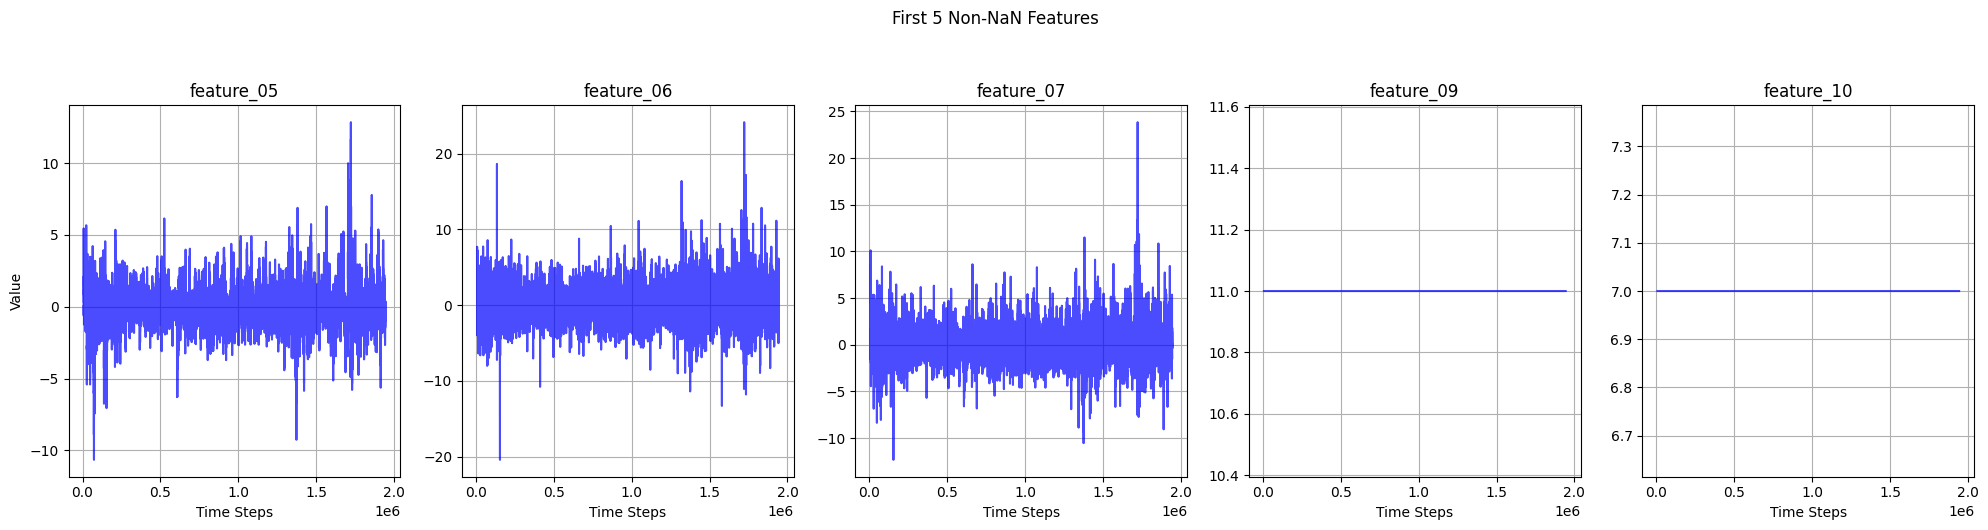

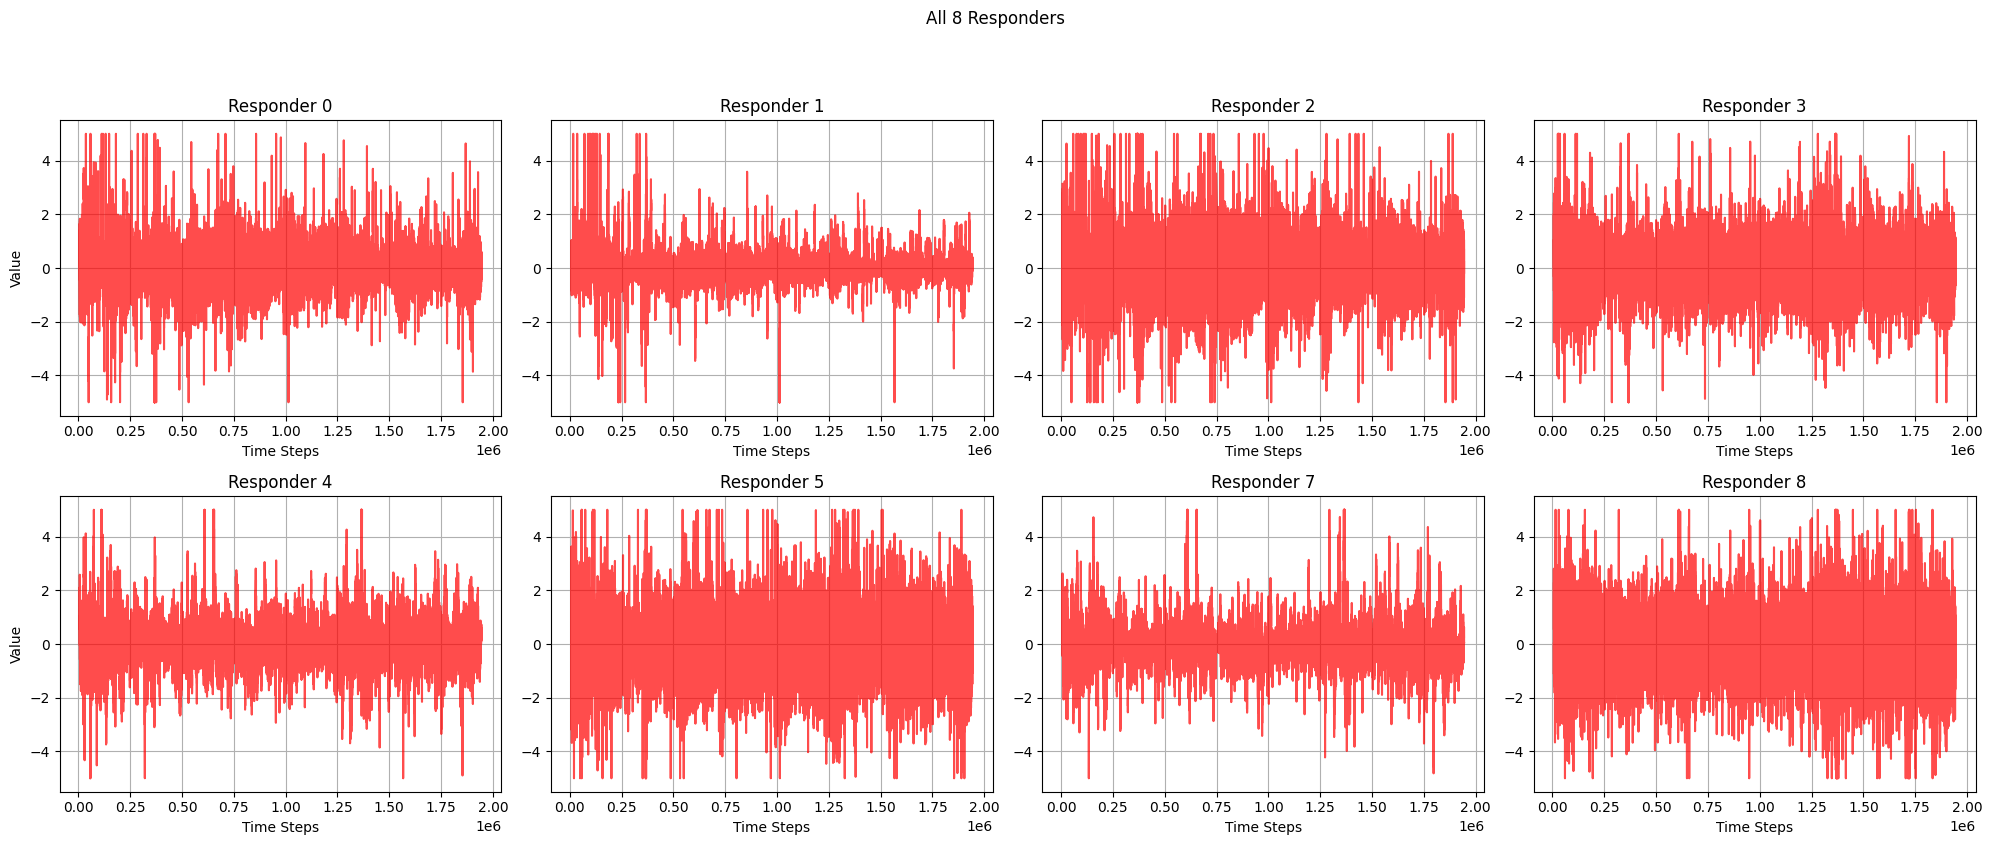

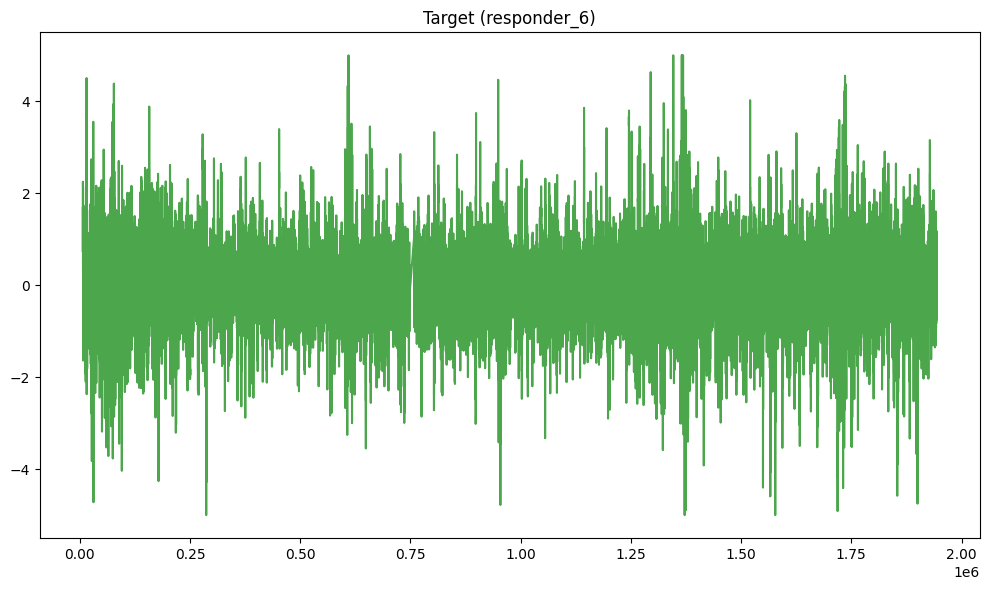

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_separate_timeseries(features, responders, target):
    """
    Create separate subplots for first 5 features and all 8 responders
    """
    plt.figure(figsize=(20, 5))
    clean_features_plotted = 0
    all_features = features.columns
    
    # Keep plotting until we get 5 clean features
    for feature_name in all_features:
        # Check if this feature has any NaN
        if not features[feature_name].isna().any():
            ax = plt.subplot(1, 5, clean_features_plotted + 1)
            timeseries = features[feature_name]
            ax.plot(timeseries, color='blue', alpha=0.7)
            ax.set_title(feature_name)
            ax.grid(True)
            if clean_features_plotted == 0:
                ax.set_ylabel('Value')
            ax.set_xlabel('Time Steps')
            
            clean_features_plotted += 1
            if clean_features_plotted == 5:  # Stop after 5 clean features
                break
    
    plt.suptitle('First 5 Non-NaN Features', y=1.05)
    plt.tight_layout()
    plt.show()

    # Second plot - Responders
    plt.figure(figsize=(20, 8))
    for i, col in enumerate(responders.columns):
        ax = plt.subplot(2, 4, i+1)  # 2 rows, 4 columns
        ax.plot(responders[col], color='red', alpha=0.7)
        ax.set_title(f'Responder {col[-1]}')
        ax.grid(True)
        if i % 4 == 0:  # Add y-label for leftmost plots
            ax.set_ylabel('Value')
        ax.set_xlabel('Time Steps')
    plt.suptitle('All 8 Responders', y=1.05)
    plt.tight_layout()
    plt.show()

    # Third plot - Target
    plt.figure(figsize=(10, 6))
    plt.plot(target, color='green', alpha=0.7)
    plt.title('Target (responder_6)')
    plt.tight_layout()
    plt.show()


# Example usage
if __name__ == "__main__":
    # Load data
    df = pd.read_parquet("train.parquet/partition_id=0/part-0.parquet")
    symbol_id = df['symbol_id'].unique()[0]
    
    # Create time series
    features, responders, target = create_timeseries_for_symbol(df, symbol_id)
    
    # Plot
    plot_separate_timeseries(features, responders, target)


Feature series shape: (142632, 79)

First few rows of feature series:
      feature_00  feature_01  feature_02  feature_03  feature_04  feature_05  \
6793         NaN         NaN         NaN         NaN         NaN    0.053053   
6805         NaN         NaN         NaN         NaN         NaN   -0.018100   
6817         NaN         NaN         NaN         NaN         NaN    0.025724   
6829         NaN         NaN         NaN         NaN         NaN    0.338659   
6841         NaN         NaN         NaN         NaN         NaN   -0.025732   

      feature_06  feature_07  feature_08  feature_09  ...  feature_69  \
6793    2.126396    1.101112   -0.013003          11  ...   -0.017244   
6805    1.100362    0.637041    0.006862          11  ...   -0.030352   
6817    0.557739    0.624361   -0.006144          11  ...   -0.054178   
6829    2.194375    1.743228   -0.046745          11  ...   -0.085421   
6841   -0.396735    0.867105    0.006796          11  ...   -0.104070   

      fea

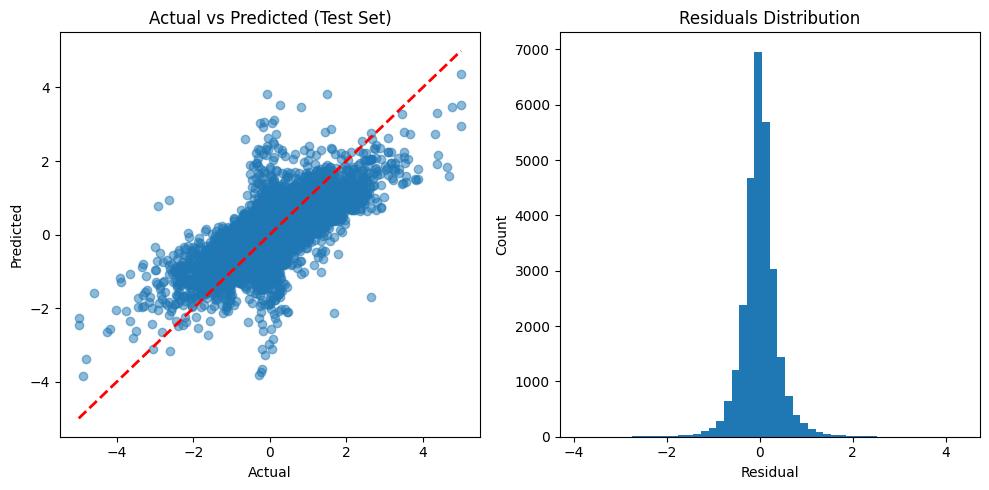

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def prepare_regression_data(features, responders, target):
    """
    Prepare X and y for regression by:
    1. Removing features with NaN
    2. Combining clean features with responders
    3. Aligning with target
    """
    # Get clean features (no NaN)
    clean_features = features.loc[:, ~features.isna().any()].reset_index(drop=True)
    responders = responders.reset_index(drop=True)
    target = target.reset_index(drop=True)
    
    print(f"Number of clean features: {len(clean_features.columns)}")
    
    # Make sure all have same length
    min_len = min(len(clean_features), len(responders), len(target))
    clean_features = clean_features.iloc[:min_len]
    responders = responders.iloc[:min_len]
    target = target.iloc[:min_len]
    
    # Combine clean features and responders for X
    X = pd.concat([clean_features, responders], axis=1)
    y = target
    
    print("\nRegression data shapes:")
    print(f"X shape: {X.shape} (samples, features+responders)")
    print(f"y shape: {y.shape}")
    
    # Print first few column names to verify
    print("\nFirst few X columns:")
    print("Features:", clean_features.columns[:5].tolist())
    print("Responders:", responders.columns[:5].tolist())
    
    return X, y

def train_model(X, y):
    """
    Train a linear regression model
    """
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Train/Test split sizes:")
    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    return model, X_train, X_test, y_train, y_test

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluate its performance
    """
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print("\nModel Performance:")
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    # Plot actual vs predicted for test set
    plt.figure(figsize=(10, 5))
    
    # First subplot: Actual vs Predicted scatter
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted (Test Set)')
    
    # Second subplot: Residuals
    plt.subplot(1, 2, 2)
    residuals = y_test - y_test_pred
    plt.hist(residuals, bins=50)
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.title('Residuals Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return model

# Example usage
if __name__ == "__main__":
    # Load data
    df = pd.read_parquet("train.parquet/partition_id=0/part-0.parquet")
    symbol_id = df['symbol_id'].unique()[0]
    
    # Create time series
    features, responders, target = create_timeseries_for_symbol(df, symbol_id)
    
    # Prepare regression data
    X, y = prepare_regression_data(features, responders, target)
    
    # Train and evaluate model
    model, X_train, X_test, y_train, y_test = train_model(X, y)
    evaluate_model(model, X_train, X_test, y_train, y_test)


Feature series shape: (142632, 79)

First few rows of feature series:
      feature_00  feature_01  feature_02  feature_03  feature_04  feature_05  \
6793         NaN         NaN         NaN         NaN         NaN    0.053053   
6805         NaN         NaN         NaN         NaN         NaN   -0.018100   
6817         NaN         NaN         NaN         NaN         NaN    0.025724   
6829         NaN         NaN         NaN         NaN         NaN    0.338659   
6841         NaN         NaN         NaN         NaN         NaN   -0.025732   

      feature_06  feature_07  feature_08  feature_09  ...  feature_69  \
6793    2.126396    1.101112   -0.013003          11  ...   -0.017244   
6805    1.100362    0.637041    0.006862          11  ...   -0.030352   
6817    0.557739    0.624361   -0.006144          11  ...   -0.054178   
6829    2.194375    1.743228   -0.046745          11  ...   -0.085421   
6841   -0.396735    0.867105    0.006796          11  ...   -0.104070   

      fea

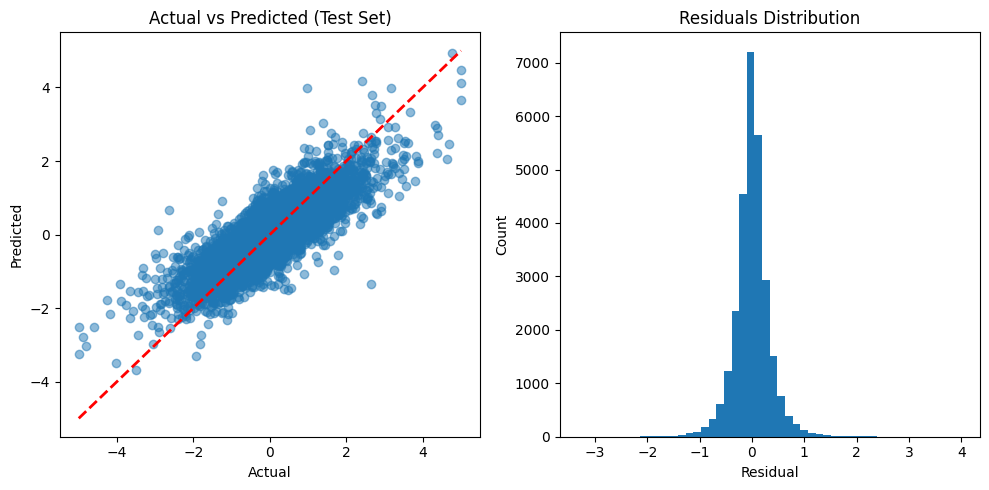


Top 10 most important features:
        feature  importance
46  responder_3    0.221125
43  responder_0    0.133403
49  responder_7    0.128219
8    feature_14    0.035700
30   feature_59    0.028504
35   feature_69    0.028181
18   feature_29    0.023893
16   feature_25    0.022367
47  responder_4    0.021036
1    feature_06    0.019307


In [5]:
from xgboost import XGBRegressor

def prepare_regression_data_responders_only(features, responders, target):
    """
    Prepare X and y for regression using only responders
    """
    # Reset indices
    responders = responders.reset_index(drop=True)
    target = target.reset_index(drop=True)
    
    # Make sure all have same length
    min_len = min(len(responders), len(target))
    responders = responders.iloc[:min_len]
    target = target.iloc[:min_len]
    
    # X is just responders
    X = responders
    y = target
    
    print("\nRegression data shapes:")
    print(f"X shape: {X.shape} (samples, responders)")
    print(f"y shape: {y.shape}")
    print("\nResponder columns:")
    print("Responders:", X.columns.tolist())
    
    return X, y

def prepare_regression_data_top3_responders(features, responders, target):
    """
    Prepare X and y for regression using only top 3 responders (3, 0, and 7)
    """
    # Reset indices
    responders = responders.reset_index(drop=True)
    target = target.reset_index(drop=True)
    
    # Make sure all have same length
    min_len = min(len(responders), len(target))
    responders = responders.iloc[:min_len]
    target = target.iloc[:min_len]
    
    # Select only top 3 responders
    top_responders = ['responder_3', 'responder_0', 'responder_7']
    X = responders[top_responders]
    y = target
    
    print("\nRegression data shapes:")
    print(f"X shape: {X.shape} (samples, top 3 responders)")
    print(f"y shape: {y.shape}")
    print("\nTop 3 responder columns:")
    print("Responders:", X.columns.tolist())
    
    return X, y

def train_xgboost_model(X, y):
    """
    Train an XGBoost regression model with basic hyperparameters
    """
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Train/Test split sizes:")
    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    
    # Initialize and train model
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )
    
    # Train the model with eval set for validation
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )
    
    return model, X_train, X_test, y_train, y_test

# Example usage
if __name__ == "__main__":
    # Load data
    df = pd.read_parquet("train.parquet/partition_id=0/part-0.parquet")
    symbol_id = df['symbol_id'].unique()[0]
    
    # Create time series
    features, responders, target = create_timeseries_for_symbol(df, symbol_id)
    
    # Prepare regression data
    X, y = prepare_regression_data(features, responders, target)
    
    # Train and evaluate model
    model, X_train, X_test, y_train, y_test = train_xgboost_model(X, y)
    evaluate_model(model, X_train, X_test, y_train, y_test)

    # Print feature importances
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))


Feature series shape: (142632, 79)

First few rows of feature series:
      feature_00  feature_01  feature_02  feature_03  feature_04  feature_05  \
6793         NaN         NaN         NaN         NaN         NaN    0.053053   
6805         NaN         NaN         NaN         NaN         NaN   -0.018100   
6817         NaN         NaN         NaN         NaN         NaN    0.025724   
6829         NaN         NaN         NaN         NaN         NaN    0.338659   
6841         NaN         NaN         NaN         NaN         NaN   -0.025732   

      feature_06  feature_07  feature_08  feature_09  ...  feature_69  \
6793    2.126396    1.101112   -0.013003          11  ...   -0.017244   
6805    1.100362    0.637041    0.006862          11  ...   -0.030352   
6817    0.557739    0.624361   -0.006144          11  ...   -0.054178   
6829    2.194375    1.743228   -0.046745          11  ...   -0.085421   
6841   -0.396735    0.867105    0.006796          11  ...   -0.104070   

      fea

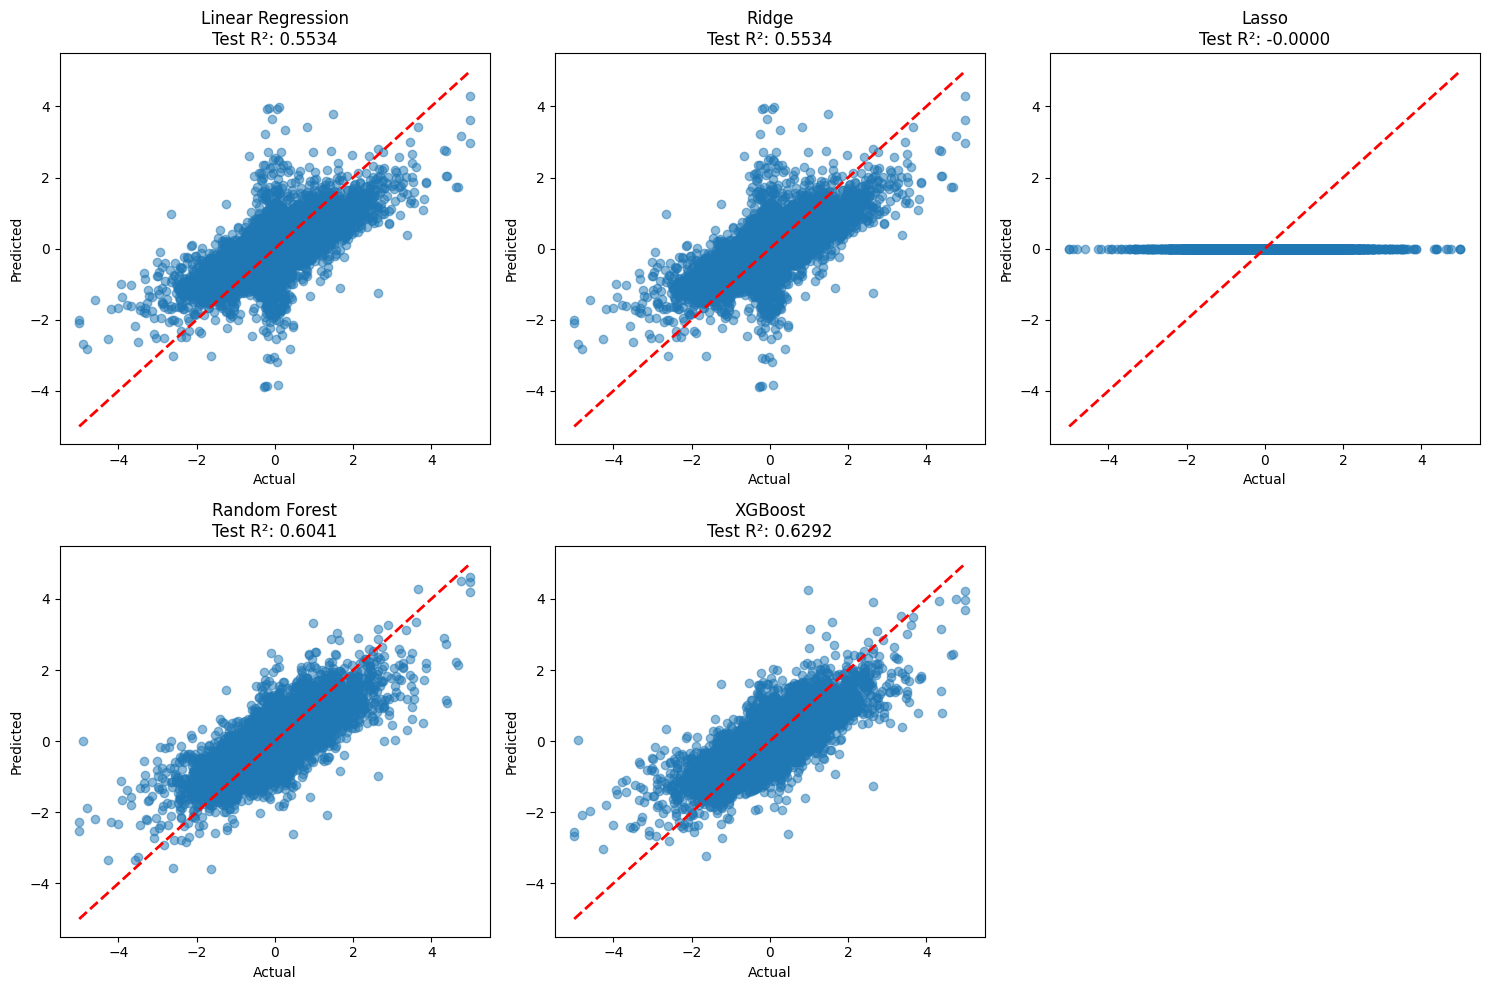

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def train_and_evaluate_multiple_models(X, y):
    """
    Train and evaluate multiple models on the same data
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
    }
    
    # Train and evaluate each model
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Calculate metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        print(f"{name} Performance:")
        print(f"Train MSE: {train_mse:.4f}")
        print(f"Test MSE: {test_mse:.4f}")
        print(f"Train R²: {train_r2:.4f}")
        print(f"Test R²: {test_r2:.4f}")
        
        # Store results
        results[name] = {
            'model': model,
            'test_pred': y_test_pred,
            'test_actual': y_test,
            'metrics': {
                'train_mse': train_mse,
                'test_mse': test_mse,
                'train_r2': train_r2,
                'test_r2': test_r2
            }
        }
    
    # Plot comparison of actual vs predicted for all models
    plt.figure(figsize=(15, 10))
    for i, (name, result) in enumerate(results.items(), 1):
        plt.subplot(2, 3, i)
        plt.scatter(result['test_actual'], result['test_pred'], alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'{name}\nTest R²: {result["metrics"]["test_r2"]:.4f}')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Example usage
if __name__ == "__main__":
    # Load and prepare data
    df = pd.read_parquet("train.parquet/partition_id=0/part-0.parquet")
    symbol_id = df['symbol_id'].unique()[0]
    features, responders, target = create_timeseries_for_symbol(df, symbol_id)
    X, y = prepare_regression_data_top3_responders(features, responders, target)
    
    # Train and evaluate multiple models
    results = train_and_evaluate_multiple_models(X, y)


Feature series shape: (142632, 79)

First few rows of feature series:
      feature_00  feature_01  feature_02  feature_03  feature_04  feature_05  \
6793         NaN         NaN         NaN         NaN         NaN    0.053053   
6805         NaN         NaN         NaN         NaN         NaN   -0.018100   
6817         NaN         NaN         NaN         NaN         NaN    0.025724   
6829         NaN         NaN         NaN         NaN         NaN    0.338659   
6841         NaN         NaN         NaN         NaN         NaN   -0.025732   

      feature_06  feature_07  feature_08  feature_09  ...  feature_69  \
6793    2.126396    1.101112   -0.013003          11  ...   -0.017244   
6805    1.100362    0.637041    0.006862          11  ...   -0.030352   
6817    0.557739    0.624361   -0.006144          11  ...   -0.054178   
6829    2.194375    1.743228   -0.046745          11  ...   -0.085421   
6841   -0.396735    0.867105    0.006796          11  ...   -0.104070   

      fea

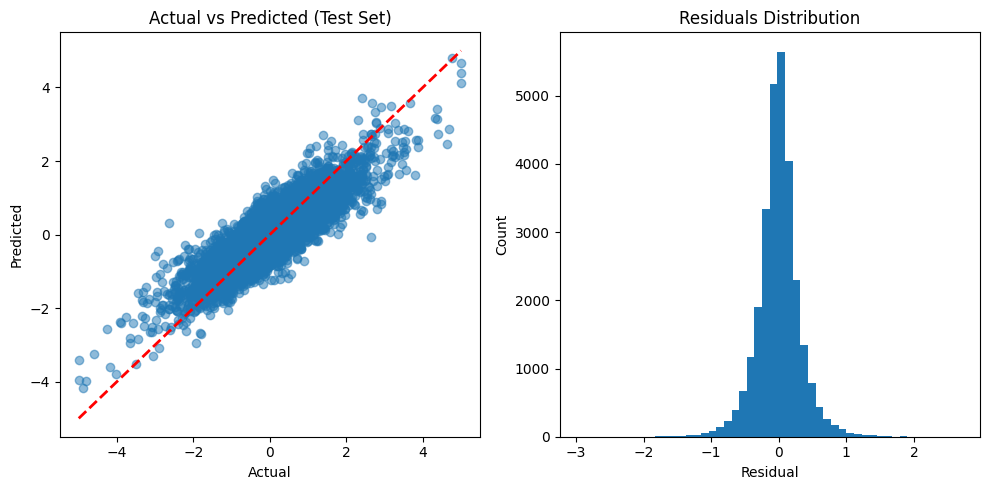

In [7]:
from sklearn.model_selection import GridSearchCV

def tune_xgboost(X, y):
    """
    Tune XGBoost hyperparameters using a focused parameter grid
    """
    # Define smaller parameter grid
    param_grid = {
        'n_estimators': [100, 200],          # removed 300
        'max_depth': [4, 6],                 # just 2 values
        'learning_rate': [0.01, 0.1],        # removed middle value
        'subsample': [0.8, 1.0],             # removed 0.9
        'min_child_weight': [1, 3]           # removed 5
    }
    
    # Calculate total combinations
    total_combinations = 2 * 2 * 2 * 2 * 2  # = 32 combinations
    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total fits with 5-fold CV: {total_combinations * 5}")
    
    # Initialize XGBoost model
    xgb = XGBRegressor(random_state=42)
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='r2',
        cv=5,
        n_jobs=-1,
        verbose=2
    )
    
    # Fit GridSearchCV
    grid_search.fit(X, y)
    
    # Print results
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"\nBest cross-validation R²: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

# Example usage
if __name__ == "__main__":
    # Load and prepare data (with all features and responders)
    df = pd.read_parquet("train.parquet/partition_id=0/part-0.parquet")
    symbol_id = df['symbol_id'].unique()[0]
    features, responders, target = create_timeseries_for_symbol(df, symbol_id)
    X, y = prepare_regression_data(features, responders, target)
    
    # Tune model
    best_model = tune_xgboost(X, y)
    
    # Evaluate best model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    evaluate_model(best_model, X_train, X_test, y_train, y_test)